# Intro

Steps to create a graph with memory
1. install required packages like langchain_openai, langchain_core, langgraph.
    - langchain_openai has function to connect with openai model.
    - langchain_core has inbuild message types like AI message, HumanMessage, SystemMessage, ToolMessage. Each message consist of 
        - Content
        - name
        - response_metadata
    - langgraph has types and models to create the graphs.
2. Define the state for node by predefined MessageSystem or Custom state with reducer using TypedDict.
3. Define any tool_calling if required.
4. Create LLM connection and add the tool_calling.
5. Create the LLM node.
6. Create the graph with node, edge and edge conditions if needed.
7. Generate graph flow.
8. Run and test the graph.

# Code

## Step 1 (Installing packages)

In [2]:
%pip install --quiet -U langchain_openai langchain_core langgraph

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Step 2 (Define State)

In [3]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class CustomMessageState(TypedDict):
        messages:list[AnyMessage]

class CustomMessageStateWithString(TypedDict):
        message:str

## Step 3 (Define Tool Calling)

In [11]:
def Multiply(a:int, b:int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a*b

## Step 4 (Make LLM connection and add Tool Calling)

In [12]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv() # loading api keys

llm=ChatOpenAI(model="gpt-4o",name="model")

tools=[Multiply]

llm_with_tool=llm.bind_tools(tools,parallel_tool_calls=False)

## Step 5 (Creating LLM node)

In [13]:
from langchain_core.messages import SystemMessage

sysMsg = SystemMessage(content="You will be an assistant to perfrom math operations")


def assistant1(state:CustomMessageState):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

def assistant2(state:CustomMessageStateWithString):
    return llm_with_tool.invoke(state)

## Step 6 and 7(Create graph and display)

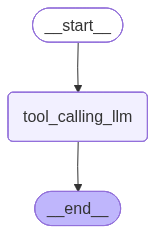

In [14]:
from langgraph.graph import StateGraph, END, START
from IPython.display import Image, display

# graph 1 with customMessageState
builder1 = StateGraph(CustomMessageState)

# creating a chain
builder1.add_node("tool_calling_llm",assistant1)
builder1.add_edge(START,"tool_calling_llm")
builder1.add_edge("tool_calling_llm",END)

# create graph
graph1 = builder1.compile()

# display the flow
display(Image(graph1.get_graph().draw_mermaid_png()))

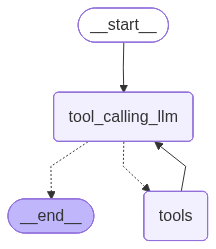

In [22]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


# graph 2 with CustomMessageStateWithString
builder2 = StateGraph(CustomMessageState) 

# creating a graph
builder2.add_node("tool_calling_llm",assistant2)
builder2.add_node("tools",ToolNode(tools))
builder2.add_edge(START,"tool_calling_llm")
builder2.add_conditional_edges("tool_calling_llm",tools_condition)
builder2.add_edge("tools","tool_calling_llm") # giving the flow back to assistant

# create graph
graph2= builder2.compile()

display(Image(graph2.get_graph().draw_mermaid_png()))

## Step 8 (Run and Test)

In [29]:
# Make sure to import the necessary message type from langchain_core
from langchain_core.messages import HumanMessage

# Your compiled graph object (assuming it's named 'app' or 'graph')
# app = graph.compile() 

# 1. Define the input message as a list
#    Even if there's only one message, it must be inside a list.
input_messages = [HumanMessage(content="Multiply 2 and 4")]

# 2. Create the input dictionary with the 'messages' key
#    This structure matches your graph's state (CustomMessageState)
graph_input = {"messages": input_messages}

# 3. Invoke the graph with the correctly structured dictionary
response = graph1.invoke(graph_input)

print(response)

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_XFbruKD5usi4Gk1OLv61QzJZ', 'function': {'arguments': '{"a":2,"b":4}', 'name': 'Multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 58, 'total_tokens': 76, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f33640a400', 'id': 'chatcmpl-CK7qPSnj1MqhWgaG9YmzVD1LYp1Nf', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--265a8117-b3ab-48d9-b2c6-da653adaa619-0', tool_calls=[{'name': 'Multiply', 'args': {'a': 2, 'b': 4}, 'id': 'call_XFbruKD5usi4Gk1OLv61QzJZ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 58, 'output_tokens': 18, 'total_tokens': 76, 'input_token_details': {'audio':